# COMP24112 - Exercise 3: _Face Recognition_ (25 Marks)

## 1. Task description

You will work on the face recognition and face completion tasks. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

## 2. Preparation

### 2.1 Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [342]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt


Now you can load the data:

In [343]:
data, labels = load_data()

### 2.2 Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

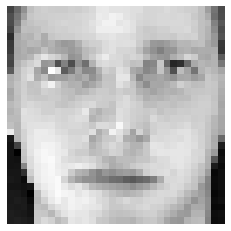

In [344]:
# Display a single example.
show_single_face(data[0, :])

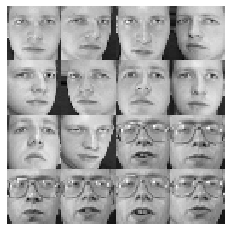

In [345]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### 2.3 Splitting into the train and test sets

First, normalize your pixel values by 1/255 so that the feature values used in later experiments are between $[0,1]$. In general, the normalization trick can make it easier for your to tune parameters in machine learning experiments.

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. The function takes the labels and the specified number $N$ as the input. And returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [346]:
# normalization
data = data / 255

# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

## 3. $L_2$-regularised least squares (13 Marks in Total)
### 3.1 Implementation (5 Marks, Easy)
Now, you need to implement the function `l2_rls_train` below. 

`l2_rls_train` trains a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ as the input, and return the predicted weights. When $\lambda=0$, use a pseudo-inverse to implement the solution.

In [347]:
def l2_rls_train(data, labels,hyperparameter  # Add any other arguments here
          ):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    column_len = X.shape[0]
    
    # Expand X with a column of ones.
    
    X_tilde = np.c_[np.ones(column_len,dtype =int),X]
#     print(X_tilde.shape[0])
    if hyperparameter > 0:
        # Compute the coefficient vector.
        I_matrix = np.identity(X.shape[1]+1)
        first = X_tilde.T@X_tilde
        second = (hyperparameter*I_matrix)
        third = X_tilde.T@ np.array(y)

    #     print(np.linalg.inv((X_tilde.T@X_tilde) + (hyperparameter*I_matrix)))
        w = (np.linalg.inv(first + second))@ third
    else:
        w = np.linalg.pinv(X_tilde)@y
        # Return model parameters.
    return w

l2_rls_train(tr_data,tr_label,0)

array([17.83913198,  3.05112441,  0.53078099, ..., -1.95584186,
        4.57601374,  0.43000491])

Now, implement the function `l2_rls_predict` below. It should take the trained weights and your query data as the input, and return the corresponding prediction.

In [348]:
def l2_rls_predict(w, data):
    """
    A summary of your function goes here.

    data: type and description of "data"
    w: type and description of "w"

    Returns: type and description of the returned variable(s).
    """
    X= data
    
    column_len = X.shape[0]
    
    # Expand X with a column of ones.
    
    X_tilde = np.c_[np.ones(column_len),X]
    
   # Compute the prediction.
    predicted_y = X_tilde @ w
#     print(predicted_y)
    return predicted_y

l2_rls_predict(l2_rls_train(tr_data,tr_label,0),te_data)

array([ 12.48845668,   4.9026245 ,  21.10101482,   0.43693785,
        34.28443067,  -3.72625154,   7.53145643,  16.56649419,
         2.98976531,  -4.4010256 ,   6.98099617,   4.74231415,
         5.03403245,  12.48239284,  21.58858635,  25.55332573,
        17.57336352,   2.90781814,  20.49038208,   8.44559196,
        -0.39882546,   2.18874877,   4.84922718,  12.01575707,
         2.53006552,   3.20924858, -12.14351868,   6.75591513,
        17.31843491,  17.93178713,  15.79521213,  18.17678442,
        22.39854252,  15.43501985,  15.48800216,  21.92782568,
        16.9081069 ,  17.37692706,  11.00442062,   8.8695558 ,
        15.26760513,  19.27729781,  25.53301939,  -0.40464953,
        10.12687307,  25.87536881,  12.590587  ,  10.17741053,
        19.23228926,  13.69946353,  27.30640787,   4.12488555,
        26.190854  ,  20.99964925,  15.42609941,  34.96035762,
        10.42788357,  14.5598857 ,   5.29516854,  15.55915779,
         6.9238105 ,  13.2934288 ,  13.60153418,   8.48

#### Report

Explain briefly the knowledge supported your implementation and your design step by step.

### 3.2 Experiments (2 experiments to be implemented) 

Use your implemented functions to perform the following experiments. Experiment 1 is compulsory. Between Experiment 2 and Experiment 3, choose one as you like.

#### Experiment 1: Binary Classification (4 Marks, Normal)

Start with a binary classification to classify face images for subjects “1” and “30”.

Train three classifiers:
<br>Classifier 1. Set $y=-1$ for samples from “1” and $y=+1$ for samples from “30” for training a linear model, and use the threshold $T= 0$ to obtain the class prediction.
<br>Classifier 2. Set $y=0$ for samples from “1” and $y=1$ for samples from “30” for training a linear model, and use the threshold $T= 0.5$ to obtain the class prediction.
<br>Classifier 3. Set $y=1$ for samples from “1” and $y=30$ for samples from “30” for training a linear model, and use the threshold $T= 15.5$ to obtain the class prediction.

Randomly select 3 images per subject for training, and use the remaining images for testing. Train your classifier 1 and test it with a fixed regularisation parameter $\lambda$=0. Repeat this process 50 times and record the training and test errors.

In [349]:
# Your code goes here
def classifier(threshold,value_1,value_30):
    data_1 = data[0:10]
    # print(data_1)
    label_1 = [value_1] *10
    # print(label_1)
    data_30 = data[290:300]
    # print(data_30)
    label_30 = [value_30] *10
    # print(label_30)

    label_train = np.concatenate((label_1 , label_30))
    data_train = np.concatenate((data_1 , data_30))

    tr_ind, te_ind = partition_data(label_train, num_per_class=3)
    tr_data = data_train[tr_ind, :]
    tr_label = label_train[tr_ind]
    te_data = data_train[te_ind, :]
    te_label = label_train[te_ind]
    
    #training 
    y_predict = l2_rls_predict(l2_rls_train(tr_data,tr_label,0),tr_data)
    
    classify =[]
    for i in y_predict:
        if i > threshold:
            classify.append(value_30)
        else:
            classify.append(value_1)    
    train_err = 1- (np.sum(np.array(classify) == tr_label))/6
    print("training error : " ,train_err)


    #testing 
    y_predict = l2_rls_predict(l2_rls_train(tr_data,tr_label,0),te_data)
    
    classify =[]
    for i in y_predict:
        if i > threshold:
            classify.append(value_30)
        else:
            classify.append(value_1)    
    test_err = 1- (np.sum(np.array(classify) == te_label))/14
    print("testing error: " , test_err)
    print("##################################")
    return train_err,test_err

In [350]:
# Your code goes here
train_error_1 =[]
test_error_1 =[]
for j in range(50):
    tr_err,te_err = classifier(0,-1,1)
    train_error_1.append(tr_err)
    test_error_1.append(te_err)

training error :  0.0
testing error:  0.0714285714285714
##################################
training error :  0.0
testing error:  0.0
##################################
training error :  0.0
testing error:  0.0
##################################
training error :  0.0
testing error:  0.2142857142857143
##################################
training error :  0.0
testing error:  0.0
##################################
training error :  0.0
testing error:  0.0
##################################
training error :  0.0
testing error:  0.0
##################################
training error :  0.0
testing error:  0.2142857142857143
##################################
training error :  0.0
testing error:  0.0
##################################
training error :  0.0
testing error:  0.2142857142857143
##################################
training error :  0.0
testing error:  0.0
##################################
training error :  0.0
testing error:  0.0
##################################
training error :

Repeat the same experiment for classifier 2.

In [351]:
# Your code goes here
train_error_2 =[]
test_error_2 =[]
for j in range(50):
    tr_err,te_err = classifier(0.5,0,1)
    train_error_2.append(tr_err)
    test_error_2.append(te_err)    

training error :  0.0
testing error:  0.0
##################################
training error :  0.0
testing error:  0.2142857142857143
##################################
training error :  0.0
testing error:  0.0714285714285714
##################################
training error :  0.0
testing error:  0.0714285714285714
##################################
training error :  0.0
testing error:  0.0
##################################
training error :  0.0
testing error:  0.1428571428571429
##################################
training error :  0.0
testing error:  0.1428571428571429
##################################
training error :  0.0
testing error:  0.0
##################################
training error :  0.0
testing error:  0.1428571428571429
##################################
training error :  0.0
testing error:  0.0
##################################
training error :  0.0
testing error:  0.2142857142857143
##################################
training error :  0.0
testing error:  0.0
######

Repeat the same experiment for classifier 3.

In [352]:
# Your code goes here
train_error_3 =[]
test_error_3 =[]
for j in range(50):
    tr_err,te_err = classifier(15.5,1,30)
    train_error_3.append(tr_err)
    test_error_3.append(te_err)   

training error :  0.0
testing error:  0.0
##################################
training error :  0.0
testing error:  0.0714285714285714
##################################
training error :  0.0
testing error:  0.0
##################################
training error :  0.0
testing error:  0.2142857142857143
##################################
training error :  0.0
testing error:  0.0
##################################
training error :  0.0
testing error:  0.0714285714285714
##################################
training error :  0.0
testing error:  0.0714285714285714
##################################
training error :  0.0
testing error:  0.0714285714285714
##################################
training error :  0.0
testing error:  0.0
##################################
training error :  0.0
testing error:  0.0
##################################
training error :  0.0
testing error:  0.0
##################################
training error :  0.0
testing error:  0.1428571428571429
#####################

Print out the mean and the std values of the test errors of the three classifiers.

0.06428571428571427
0.06714285714285713
0.061428571428571443
0.08237544710479142
0.10142857142857144
0.08452749824278291


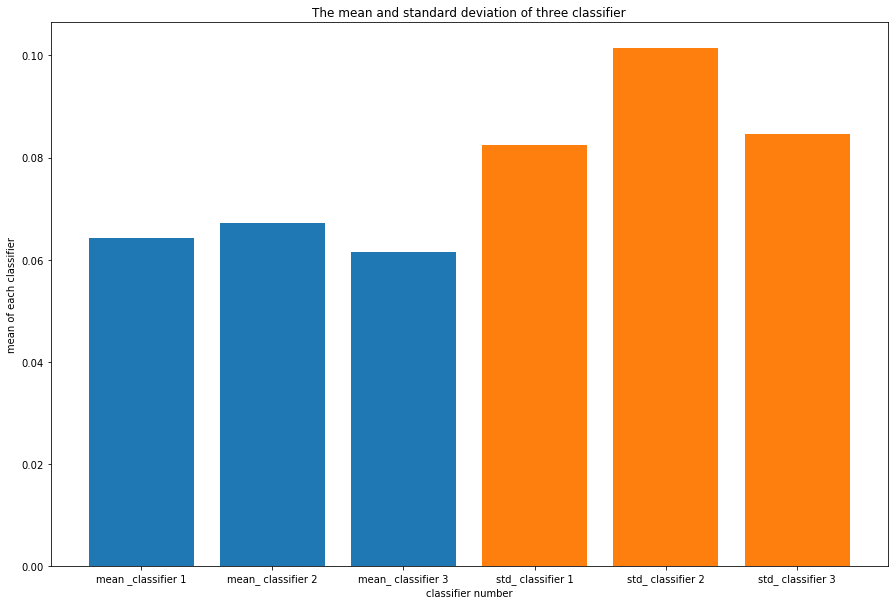

In [367]:
# Your code goes here
mean =[]
mean.append(sum(test_error_1)/50)
print(mean[0])
mean.append(sum(test_error_2)/50)
print(mean[1])
mean.append(sum(test_error_3)/50)
print(mean[2])
std_value = []
std_value1 =0
std_value2 =0
std_value3 =0
for i in test_error_1:
    std_value1 += np.power((i-mean[0]),2)
for i in test_error_2:
    std_value2 += np.power((i-mean[1]),2)
for i in test_error_3:
    std_value3 += np.power((i-mean[2]),2)

std_value.append(np.sqrt(std_value1/50)) 
std_value.append(np.sqrt(std_value2/50))
std_value.append(np.sqrt(std_value3/50))

print(std_value[0])
print(std_value[1])
print(std_value[2])

plt.figure(figsize=(15,10))
# print(x)
name = ['mean _classifier 1','mean_ classifier 2','mean_ classifier 3']
name_std = ['std_ classifier 1','std_ classifier 2','std_ classifier 3']
x = name
y = mean
plt.bar(x, y)
plt.bar(name_std,std_value)
plt.xlabel('classifier number')
plt.ylabel('mean of each classifier')
plt.title('The mean and standard deviation of three classifier')
plt.show()

#### Report

Explain the classification steps. Does changing the class labels impact the model performance? Explain why it does/doesn't impact.  What training accuracies do you obtain with your linear classifier? Analyse the reason.

#### Experiment 2: Multi-class Classification (4 Marks, Normal)

Now, proceed to the multi-class classification task to classify face images for all the 40 subjects.

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. In the evaluation, you should construct a $40\times 40$ classification error matrix (confusion matrix) for test samples. 

Write your code below and make sure it compiles. 

In [354]:
# Your code goes here
# Note that you may find it helpful to use one-hot encoding to deal with multi-class labels

 Pick some subjects that are considered the easist to recognise by your classifier, and print the test images from these subjects below.

In [355]:
# Your code goes here

 Pick some subjects that are considered the most difficult to recognise by your classifier, and print the misclassified test images from these subjects below.

In [356]:
# Your code goes here

#### Report

Explain the classification steps. How do you pick the most difficult and easiest subjects to classify,  analyse the results.

#### Experiment 3: Face Completion (4 Marks, Normal)

The task is to predic the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [357]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

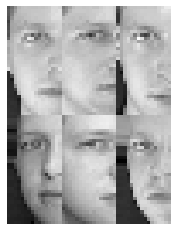

In [358]:
show_split_faces(left[:6, :], num_per_row=3)

Build a face completion model using your functions implemented earlier. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles.

In [359]:
# Your code goes here
tr_ind, te_ind = partition_data(labels, num_per_class=3)
left_tr_data = left[tr_ind, :]
left_te_data = left[te_ind, :]
right_tr_data = right[tr_ind, :]
right_te_data = right[te_ind, :]
    
y_predict = l2_rls_predict(l2_rls_train(left_tr_data,right_tr_data,0),left_te_data)
#     print(y_predict)
    
MAPE = np.mean(abs(right_te_data-y_predict)/abs(right_te_data))
print("MAPE : ", MAPE)

MAPE :  0.21762990610448918


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

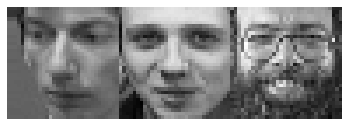

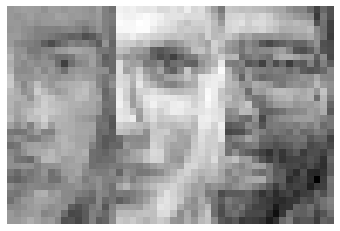

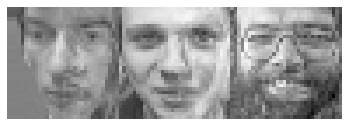

In [366]:
# Your code goes here
# print(facerecognise())
# print(te_ind)
import random
random_number= random.sample(range(0,279),3)
predict_face = join_left_right(left_te_data,y_predict)
origin_Face= data[te_ind,:]
show_faces(origin_Face[random_number],num_per_row = 3)
show_split_faces(y_predict[random_number], num_per_row=3)
show_faces(predict_face[random_number],num_per_row = 3)

#### Report

Analyse results of face completion model, how well your model performed, how it can be improved? 


## 4. Gradient descent for training linear least squares model (5 Marks in Total, Normal)

Now, implement the function `lls_gd_train` below. 

`lls_gd_train` trains a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [361]:
def lls_gd_train(data, labels, learning_rate, N):
    # Add any other arguments here if needed
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    column_len = X.shape[0]
    X_tilde = np.c_[np.ones(column_len,dtype =int),X]
    
    # Weight initialization
    w = np.zeros(X.shape[1]+1)
    w_all = []
    cost_all = []
    
    # GD update of weights
    for i in range(N):
        # cost and gradient descent of the linear least squares model
        gd = (X_tilde.T@X_tilde@w) -(X_tilde.T@y)
        cost = np.sum(np.square((y- X_tilde@w)))/2
        # Weight update
        w = w - (learning_rate * gd)
        
        # save w and cost of each iteration in w_all and cost_all 
        w_all.append(w)
        cost_all.append(cost)
    
#     print(len(cost_all))
    # Return model parameters.
    return cost_all, w_all

Apply this function to classify images from subject 1 and subject 30. You only need to conduct the experiment for one training-test trial, where 3 images from each subject are used for training and the remaining 7 images for testing.

Set your learning rate small, e.g., $\eta=10^{-3}$, and use a reasonable iteration number, e.g., $N=200$, to train your model. Plot in three figures (1) the change of your sum-of-squares error loss that you minimise, (2) the change of the classification accuracy for training samples, and (3) the change of the classification accuracy for test samples over iterations. Write your code below and make sure it compiles. 

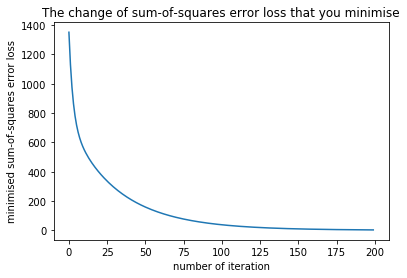

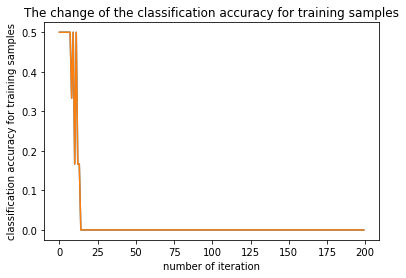

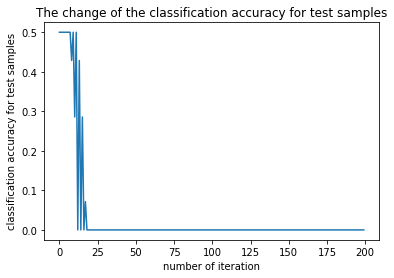

In [362]:
# Your code goes here
Iteration = 200
gd_labels =  np.concatenate((labels[0:10] , labels[290:300]))
gd_data = np.concatenate((data[0:10],data[290:300]))
gd_tr_ind, gd_te_ind = partition_data(gd_labels, num_per_class=3)
gd_tr_data = gd_data[gd_tr_ind, :]
gd_tr_label = gd_labels[gd_tr_ind]
gd_te_data = gd_data[gd_te_ind, :]
gd_te_label = gd_labels[gd_te_ind]

training_errors = []
testing_errors = []
gd_cost , gd_w = lls_gd_train(gd_tr_data,gd_tr_label,0.001,Iteration)
for i in range(Iteration):
    gd_train_y = l2_rls_predict(gd_w[i],gd_tr_data)
    predict_train_labels =[]
    for j in gd_train_y:
        if  j > 15.5:
            predict_train_labels.append(30)
        else:
            predict_train_labels.append(1)
    
    train_err = 1- (np.sum(np.array(predict_train_labels) == gd_tr_label))/6
    training_errors.append(train_err)
#     print(train_err)
    
    gd_test_y = l2_rls_predict(gd_w[i],gd_te_data)
    predict_test_labels =[]
    for j in gd_test_y:
        if  j > 15.5:
            predict_test_labels.append(30)
        else:
            predict_test_labels.append(1)
    test_err = 1- (np.sum(np.array(predict_test_labels) == gd_te_label))/14
    testing_errors.append(test_err)
#     print(test_err)

            
x = np.arange(0,200)
y = gd_cost
plt.xlabel('number of iteration')
plt.ylabel('minimised sum-of-squares error loss')
plt.title('The change of sum-of-squares error loss that you minimise')
plt.plot(x,y) 
plt.show()

x = np.arange(0,200)
y = training_errors
plt.xlabel('number of iteration')
plt.ylabel('classification accuracy for training samples')
plt.title('The change of the classification accuracy for training samples')
plt.plot(x,y) 
plt.plot(x,y) 
plt.show()



x = np.arange(0,200)
y = testing_errors
plt.xlabel('number of iteration')
plt.ylabel('classification accuracy for test samples')
plt.title('The change of the classification accuracy for test samples')
plt.plot(x,y) 
plt.show()

Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations. Write your code below and make sure it compiles. 

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-361-fe18e8c3f06f>:28: RuntimeWarning: overflow encountered in square
  cost = np.sum(np.square((y- X_tilde@w)))/2


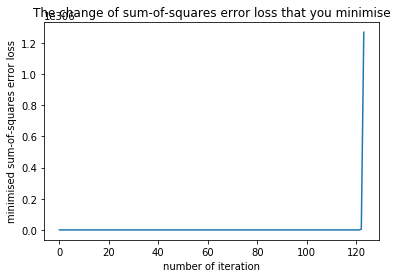

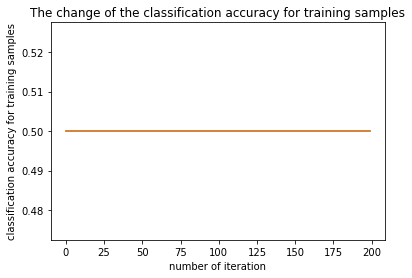

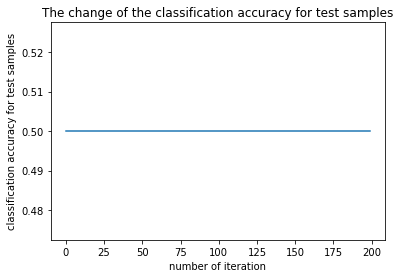

In [363]:
# Your code goes here
Iteration = 200
gd_labels =  np.concatenate((labels[0:10] , labels[290:300]))
gd_data = np.concatenate((data[0:10],data[290:300]))
gd_tr_ind, gd_te_ind = partition_data(gd_labels, num_per_class=3)
gd_tr_data = gd_data[gd_tr_ind, :]
gd_tr_label = gd_labels[gd_tr_ind]
gd_te_data = gd_data[gd_te_ind, :]
gd_te_label = gd_labels[gd_te_ind]

training_errors = []
testing_errors = []
gd_cost , gd_w = lls_gd_train(gd_tr_data,gd_tr_label,0.01,Iteration)
for i in range(Iteration):
    gd_train_y = l2_rls_predict(gd_w[i],gd_tr_data)
    predict_train_labels =[]
    for j in gd_train_y:
        if  j > 15.5:
            predict_train_labels.append(30)
        else:
            predict_train_labels.append(1)
    
    train_err = 1- (np.sum(np.array(predict_train_labels) == gd_tr_label))/6
    training_errors.append(train_err)
#     print(train_err)
    
    gd_test_y = l2_rls_predict(gd_w[i],gd_te_data)
    predict_test_labels =[]
    for j in gd_test_y:
        if  j > 15.5:
            predict_test_labels.append(30)
        else:
            predict_test_labels.append(1)
    test_err = 1- (np.sum(np.array(predict_test_labels) == gd_te_label))/14
    testing_errors.append(test_err)
#     print(test_err)

            
x = np.arange(0,200)
y = gd_cost
plt.xlabel('number of iteration')
plt.ylabel('minimised sum-of-squares error loss')
plt.title('The change of sum-of-squares error loss that you minimise')
plt.plot(x,y) 
plt.show()

x = np.arange(0,200)
y = training_errors
plt.xlabel('number of iteration')
plt.ylabel('classification accuracy for training samples')
plt.title('The change of the classification accuracy for training samples')
plt.plot(x,y) 
plt.plot(x,y) 
plt.show()



x = np.arange(0,200)
y = testing_errors
plt.xlabel('number of iteration')
plt.ylabel('classification accuracy for test samples')
plt.title('The change of the classification accuracy for test samples')
plt.plot(x,y) 
plt.show()


#### Report

How did you choose the learning rate and iteration number, explain your results.

## 5. Compare with stochastic gradient descent training (7 Marks In Total)
### 5.1 SGD Implementation (2 Marks, Normal)
Replace the gradient descent approach that you did in 4 with a stochastic gradient descent approach. Your new implementation can be named as `lls_sgd_train`. You can adopt the similar implementation template as used in your `lls_gd_train` function.

In [364]:
# Your code goes here
def lls_sgd_train(data,labels,learning_rate,N):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    column_len = X.shape[0]
    X_tilde = np.c_[np.ones(column_len,dtype =int),X]
    
    # Weight initialization
    w = np.zeros(X.shape[1]+1)
    w_all = []
    cost_all = []
    
    # GD update of weights
    for i in range(N):
        random_index = np.random.choice(X_tilde.shape[0],size =1,replace = False)
        X_tilde_index = X_tilde[random_index, :]
        y_index = y[random_index]
        
#         print(len(X_tilde_index))
#         print(len(sgd))
        # cost and gradient descent of the linear least squares model
        sgd = (X_tilde_index.T@X_tilde_index@w) - (X_tilde_index.T@y_index)
        cost = np.sum(np.square((y_index- X_tilde_index@w)))/2
        
        # Weight update
        w = w - (learning_rate * sgd)
        
        # save w and cost of each iteration in w_all and cost_all 
        w_all.append(w)
        cost_all.append(cost)
    
    # Return model parameters.
    return cost_all, w_all

### 5.2 Experiment Design (5 Marks, Hard)
Design and implement an appropriate experiment to demonstrate the perforamnce and behaviour difference between gradient descent and stochastic gradient descent. 


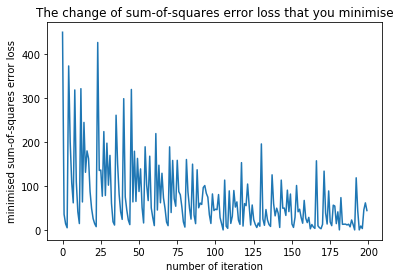

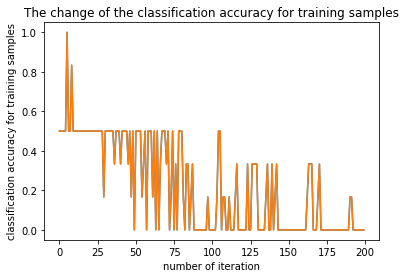

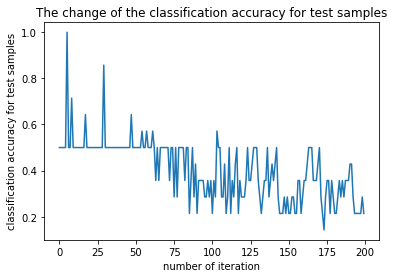

In [365]:
# Your code goes here
Iteration = 200
gd_labels =  np.concatenate((labels[0:10] , labels[290:300]))
gd_data = np.concatenate((data[0:10],data[290:300]))
gd_tr_ind, gd_te_ind = partition_data(gd_labels, num_per_class=3)
gd_tr_data = gd_data[gd_tr_ind, :]
gd_tr_label = gd_labels[gd_tr_ind]
gd_te_data = gd_data[gd_te_ind, :]
gd_te_label = gd_labels[gd_te_ind]

training_errors = []
testing_errors = []
gd_cost , gd_w = lls_sgd_train(gd_tr_data,gd_tr_label,0.001,Iteration)
for i in range(Iteration):
    gd_train_y = l2_rls_predict(gd_w[i],gd_tr_data)
    predict_train_labels =[]
    for j in gd_train_y:
        if  j > 15.5:
            predict_train_labels.append(30)
        else:
            predict_train_labels.append(1)
    
    train_err = 1- (np.sum(np.array(predict_train_labels) == gd_tr_label))/6
    training_errors.append(train_err)
#     print(train_err)
    
    gd_test_y = l2_rls_predict(gd_w[i],gd_te_data)
    predict_test_labels =[]
    for j in gd_test_y:
        if  j > 15.5:
            predict_test_labels.append(30)
        else:
            predict_test_labels.append(1)
    test_err = 1- (np.sum(np.array(predict_test_labels) == gd_te_label))/14
    testing_errors.append(test_err)
#     print(test_err)

            
x = np.arange(0,200)
y = gd_cost
plt.xlabel('number of iteration')
plt.ylabel('minimised sum-of-squares error loss')
plt.title('The change of sum-of-squares error loss that you minimise')
plt.plot(x,y) 
plt.show()

x = np.arange(0,200)
y = training_errors
plt.xlabel('number of iteration')
plt.ylabel('classification accuracy for training samples')
plt.title('The change of the classification accuracy for training samples')
plt.plot(x,y) 
plt.plot(x,y) 
plt.show()



x = np.arange(0,200)
y = testing_errors
plt.xlabel('number of iteration')
plt.ylabel('classification accuracy for test samples')
plt.title('The change of the classification accuracy for test samples')
plt.plot(x,y) 
plt.show()

#### Report  

Explain in the report your experiment design, comparative result analysis and interpretation of obtained results. Try to be thorough in your analysis.

#### Remember that all graphs should have axis labels and a title.

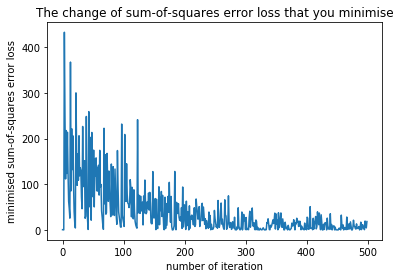

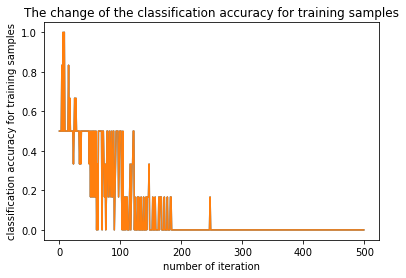

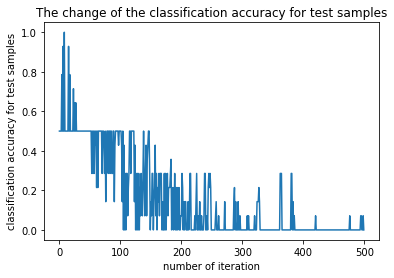

In [370]:
# Your code goes here
Iteration = 500
gd_labels =  np.concatenate((labels[0:10] , labels[290:300]))
gd_data = np.concatenate((data[0:10],data[290:300]))
gd_tr_ind, gd_te_ind = partition_data(gd_labels, num_per_class=3)
gd_tr_data = gd_data[gd_tr_ind, :]
gd_tr_label = gd_labels[gd_tr_ind]
gd_te_data = gd_data[gd_te_ind, :]
gd_te_label = gd_labels[gd_te_ind]

training_errors = []
testing_errors = []
gd_cost , gd_w = lls_sgd_train(gd_tr_data,gd_tr_label,0.001,Iteration)
for i in range(Iteration):
    gd_train_y = l2_rls_predict(gd_w[i],gd_tr_data)
    predict_train_labels =[]
    for j in gd_train_y:
        if  j > 15.5:
            predict_train_labels.append(30)
        else:
            predict_train_labels.append(1)
    
    train_err = 1- (np.sum(np.array(predict_train_labels) == gd_tr_label))/6
    training_errors.append(train_err)
#     print(train_err)
    
    gd_test_y = l2_rls_predict(gd_w[i],gd_te_data)
    predict_test_labels =[]
    for j in gd_test_y:
        if  j > 15.5:
            predict_test_labels.append(30)
        else:
            predict_test_labels.append(1)
    test_err = 1- (np.sum(np.array(predict_test_labels) == gd_te_label))/14
    testing_errors.append(test_err)
#     print(test_err)

            
x = np.arange(0,500)
y = gd_cost
plt.xlabel('number of iteration')
plt.ylabel('minimised sum-of-squares error loss')
plt.title('The change of sum-of-squares error loss that you minimise')
plt.plot(x,y) 
plt.show()

x = np.arange(0,500)
y = training_errors
plt.xlabel('number of iteration')
plt.ylabel('classification accuracy for training samples')
plt.title('The change of the classification accuracy for training samples')
plt.plot(x,y) 
plt.plot(x,y) 
plt.show()



x = np.arange(0,500)
y = testing_errors
plt.xlabel('number of iteration')
plt.ylabel('classification accuracy for test samples')
plt.title('The change of the classification accuracy for test samples')
plt.plot(x,y) 
plt.show()

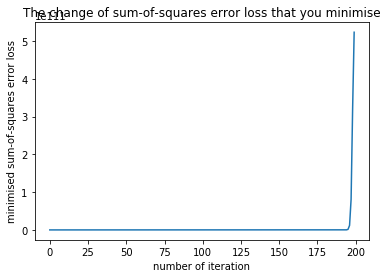

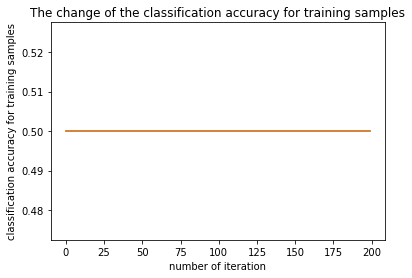

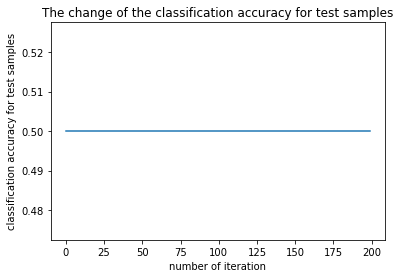

In [371]:
# Your code goes here
Iteration = 200
gd_labels =  np.concatenate((labels[0:10] , labels[290:300]))
gd_data = np.concatenate((data[0:10],data[290:300]))
gd_tr_ind, gd_te_ind = partition_data(gd_labels, num_per_class=3)
gd_tr_data = gd_data[gd_tr_ind, :]
gd_tr_label = gd_labels[gd_tr_ind]
gd_te_data = gd_data[gd_te_ind, :]
gd_te_label = gd_labels[gd_te_ind]

training_errors = []
testing_errors = []
gd_cost , gd_w = lls_sgd_train(gd_tr_data,gd_tr_label,0.01,Iteration)
for i in range(Iteration):
    gd_train_y = l2_rls_predict(gd_w[i],gd_tr_data)
    predict_train_labels =[]
    for j in gd_train_y:
        if  j > 15.5:
            predict_train_labels.append(30)
        else:
            predict_train_labels.append(1)
    
    train_err = 1- (np.sum(np.array(predict_train_labels) == gd_tr_label))/6
    training_errors.append(train_err)
#     print(train_err)
    
    gd_test_y = l2_rls_predict(gd_w[i],gd_te_data)
    predict_test_labels =[]
    for j in gd_test_y:
        if  j > 15.5:
            predict_test_labels.append(30)
        else:
            predict_test_labels.append(1)
    test_err = 1- (np.sum(np.array(predict_test_labels) == gd_te_label))/14
    testing_errors.append(test_err)
#     print(test_err)

            
x = np.arange(0,200)
y = gd_cost
plt.xlabel('number of iteration')
plt.ylabel('minimised sum-of-squares error loss')
plt.title('The change of sum-of-squares error loss that you minimise')
plt.plot(x,y) 
plt.show()

x = np.arange(0,200)
y = training_errors
plt.xlabel('number of iteration')
plt.ylabel('classification accuracy for training samples')
plt.title('The change of the classification accuracy for training samples')
plt.plot(x,y) 
plt.plot(x,y) 
plt.show()



x = np.arange(0,200)
y = testing_errors
plt.xlabel('number of iteration')
plt.ylabel('classification accuracy for test samples')
plt.title('The change of the classification accuracy for test samples')
plt.plot(x,y) 
plt.show()